# Importing datasets

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams['font.size'] = 18
plt.rcParams['font.family']
sns.set_style('darkgrid')

from tabulate import tabulate

In [2]:
import optuna

import sklearn
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score

from sklearn.naive_bayes import GaussianNB

import category_encoders as ce

In [3]:
DATA_DIR = os.path.join("..", "data")
df = pd.read_csv(
    os.path.join(DATA_DIR, "bank-additional-full.csv"), 
    sep=";",
)

# EDA

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
categorical_columns = [c for c in df if df[c].dtype == 'object']
numeric_columns = [c for c in df.columns if c not in categorical_columns]

## Preprocessing steps to be performed

$\textcolor{#AED6F1}{\underline{\textbf{Client data}}}$
1. Columns to be one-hot encoded:
    - _`job`_ (can be ordinally encoded)
    - _`marital`_
    - _`education`_ (can be ordinally encoded)
    - _`month`_
2. Check goodness of fit test between _`contact`_ and _`y`_. Whether _`contact`_ is doing anything necessary at all.
3. Drop _`day`_? 
4. Undecided on _`duration`_
5. one hot _`housing`_ and _`loan`_
6. ordinal _`default`_

$\textcolor{#A3E4D7}{\underline{\textbf{Other data}}}$  

7. Drop _`pdays`_
8. _`poutcome`_ == _`nonexistent`_ probably implies that this is that client's first campaign

$\textcolor{#F9E79F}{\underline{\textbf{Social attributes}}}$  

9. Drop all these except one after checking for correlation



In [5]:
df["y"] = LabelEncoder().fit_transform(df["y"])

In [24]:
encoder = ce.TargetEncoder(
    cols=["job", "marital", "education"],
    drop_invariant=True,
    return_df=True,
)
encoder.fit_transform(df, df["y"])

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,0.100000,0.101573,0.102490,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,0.081381,0.101573,0.108355,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,0.081381,0.101573,0.108355,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0.129726,0.101573,0.082024,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,0.081381,0.101573,0.108355,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,0.252326,0.101573,0.113485,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,0.068943,0.101573,0.113485,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,0.252326,0.101573,0.137245,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,0.108260,0.101573,0.113485,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


0    35563
Name: previous, dtype: int64


<AxesSubplot: xlabel='poutcome', ylabel='fraction'>

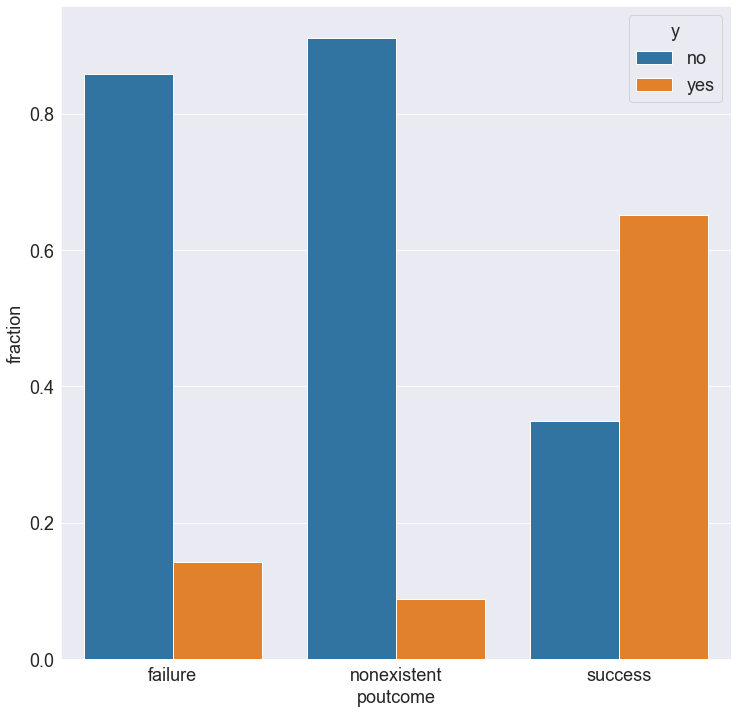

In [10]:
# if poutcome is nonexistent that means that client was not contacted previously.

print(
    df.query("poutcome == 'nonexistent'")
    .loc[:, "previous"]
    .value_counts()
)

df_temp = df.loc[:, ["poutcome", "y"]] \
        .groupby("poutcome")\
        .value_counts(normalize=True)\
        .reset_index()\
        .rename(columns={0:"fraction"})

# plt.figure(figsize=(12, 12))
sns.barplot(df_temp, x="poutcome", y="fraction", hue="y")

In [97]:
def df_to_dict(df):
    """
    If df has two columns we want a dict, where each row is a key value pair
    """
    return {k:v for k,v in df.values}


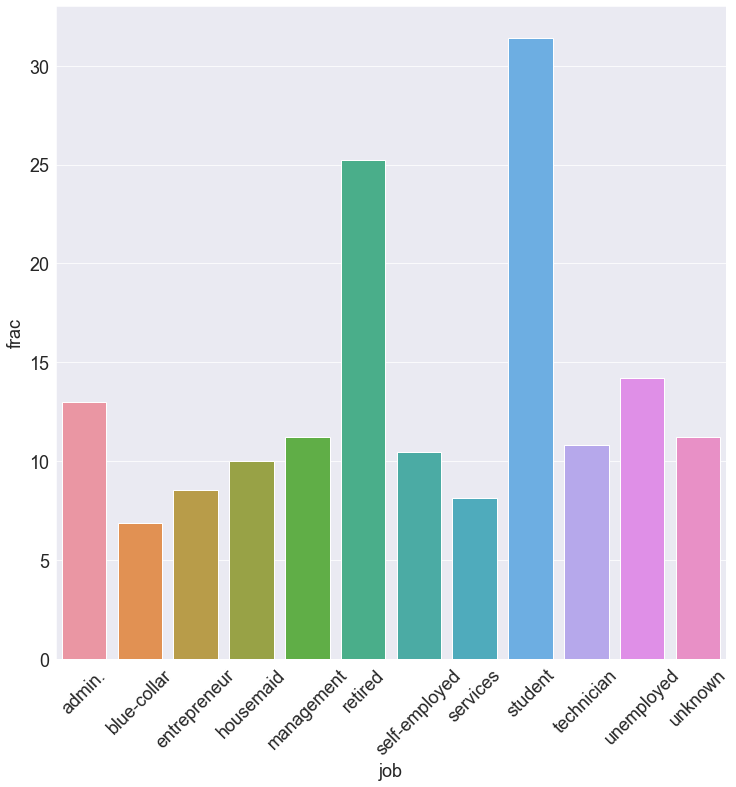

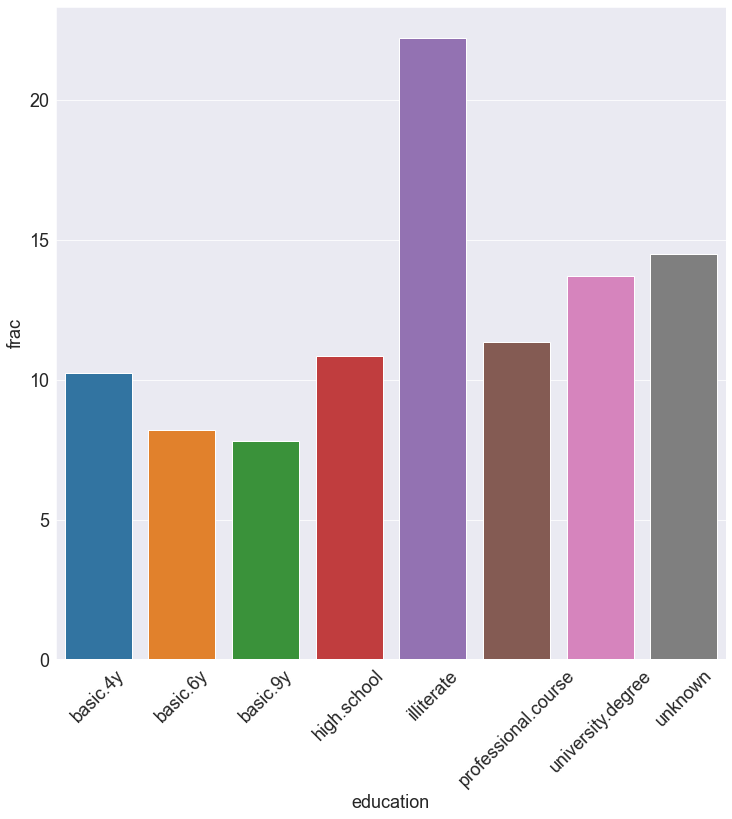

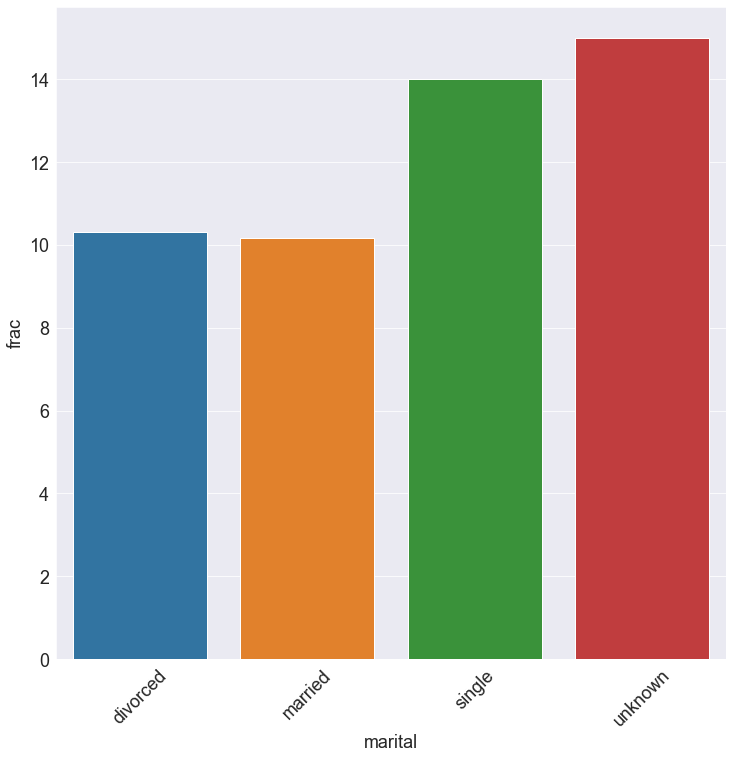

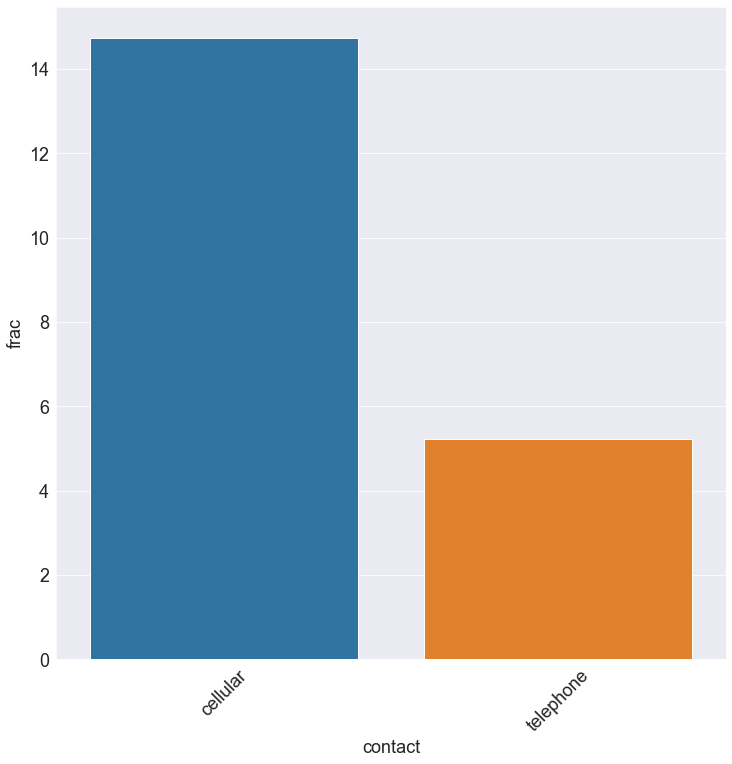

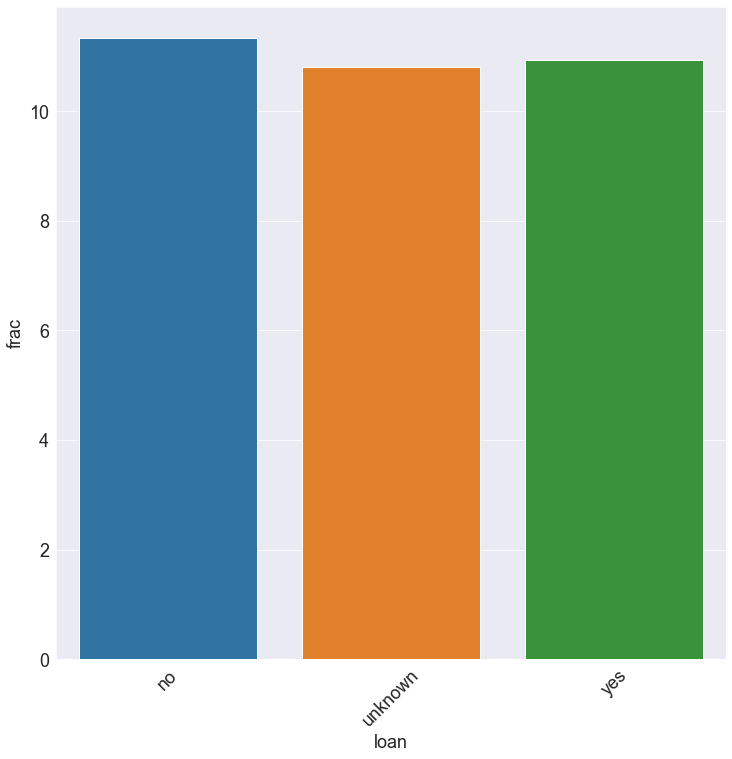

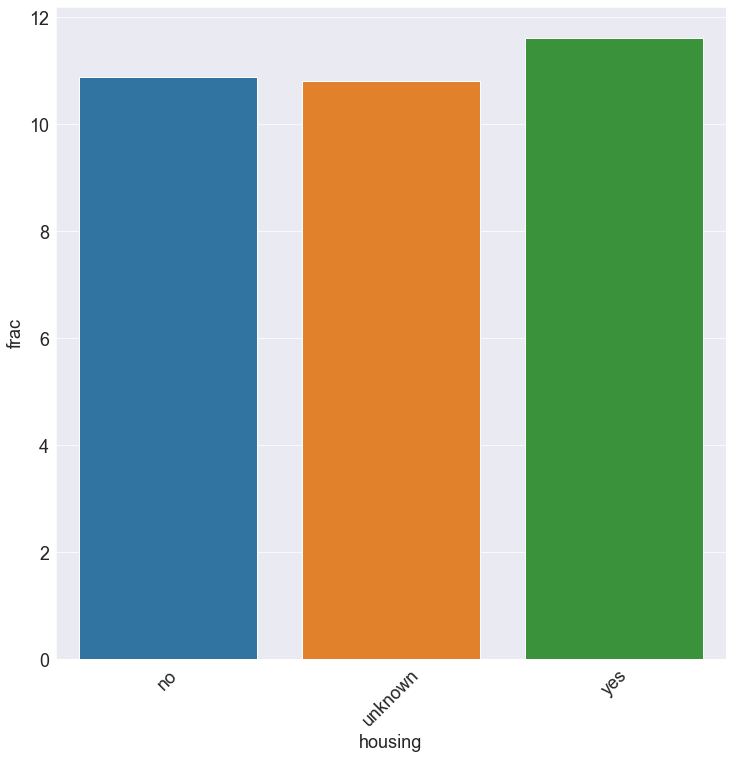

In [113]:
for c in ["job", "education", "marital", "contact", "loan", "housing"]:
        df_temp = df.loc[:, [c, "y"]] \
        .groupby(c)\
        .value_counts()\
        .reset_index()\
        .rename(columns={0:"Number"})\
        .pivot(index=c, columns="y")\
        .reset_index()

        df_temp["frac"] = 100 * df_temp[("Number", "yes")]/ (df_temp[("Number", "yes")] + df_temp[("Number", "no")])
        df_temp.columns = [c, "no", "yes", "frac"]
        mapping = df_temp.drop(columns=["no", "yes"])\
                .sort_values("frac", ascending=False)

        # plt.figure(figsize=(12, 12))
        sns.barplot(df_temp, x=c, y="frac")
        plt.xticks(rotation = 45)
        plt.show()

Looking at the above graphs we can assign some sort of ordering to the categories 

In [15]:
def success_fraction_encode(df, c):
    df_temp = df.loc[:, [c, "y"]] \
        .groupby(c)\
        .value_counts()\
        .reset_index()\
        .rename(columns={0:"Number"})\
        .pivot(index=c, columns="y")\
        .reset_index()
    df_temp["frac"] = 100 * df_temp[("Number", "yes")]/ (df_temp[("Number", "yes")] + df_temp[("Number", "no")])
    df_temp.columns = [c, "no", "yes", "frac"]
    mapping = df_temp.drop(columns=["no", "yes"])\
        .sort_values("frac", ascending=False)\
        .pipe(df_to_dict)
    return mapping
    # print(mapping)

<AxesSubplot: >

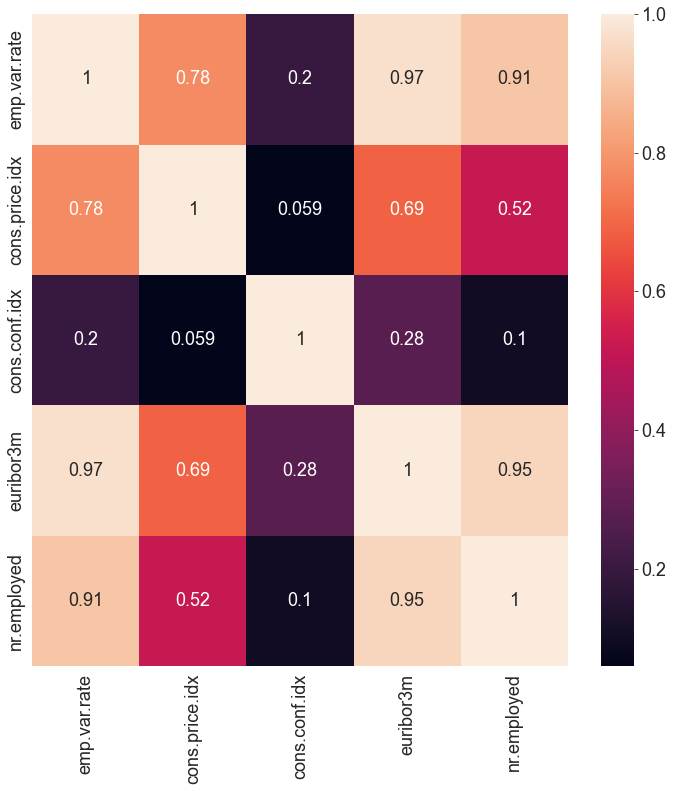

In [107]:
sns.heatmap(
    df[[
        "emp.var.rate", 
        "cons.price.idx", 
        "cons.conf.idx", 
        "euribor3m",
        "nr.employed"
    ]].corr(),
    annot=True)

Observations from the above heat map:  
1. _`euribor3m`_ is very highly correlated with _`nr.employed`_ and _`emp.var.rate`_ and moderately correlated with _`cons.price.idx`_
2. _`emp.var.rate`_ is highly correlated with _`cons.price.idx`_
3. _`cons.conf.idx`_ is not correlated with anybody

In [13]:
correlated_columns_to_be_dropped = ["emp.var.rate", "nr.employed"]

In [59]:
# how mamy unknowns are there in all the categorical columns?
def show_perc_unknown(df):
    perc = {}
    for c in categorical_columns:
        try:
            perc[c] = [
                df[c].value_counts(normalize=True)['unknown'] * 100,
                df[c].value_counts()['unknown'],
            ]
        except:
            perc[c] = [0, 0]

    print(pd.Series(perc))

In [60]:
show_perc_unknown(df)

job            [0.8012042342429834, 330]
marital         [0.1942313295134505, 80]
education      [4.202680392347285, 1731]
default        [20.87258424783918, 8597]
housing          [2.40361270272895, 990]
loan             [2.40361270272895, 990]
contact                           [0, 0]
month                             [0, 0]
day_of_week                       [0, 0]
poutcome                          [0, 0]
y                                 [0, 0]
dtype: object


In [64]:
show_perc_unknown(df
    .query("job != 'unknown'")    \
    .query("marital != 'unknown'")  \
    .loc[:,:]
)

job                                [0, 0]
marital                            [0, 0]
education      [3.9130114987618607, 1596]
default        [20.683060779169836, 8436]
housing         [2.4125334052516734, 984]
loan            [2.4125334052516734, 984]
contact                            [0, 0]
month                              [0, 0]
day_of_week                        [0, 0]
poutcome                           [0, 0]
y                                  [0, 0]
dtype: object


In [84]:
df.filter(items=['pdays']).value_counts()

pdays
999      39673
3          439
6          412
4          118
9           64
2           61
7           60
12          58
10          52
5           46
13          36
11          28
1           26
15          24
14          20
8           18
0           15
16          11
17           8
18           7
19           3
22           3
21           2
20           1
25           1
26           1
27           1
dtype: int64

In [40]:
encoder = ce.OneHotEncoder(
    cols=["job", "marital", "education"],
    drop_invariant=True,
    return_df=True,
    use_cat_names=True
)
encoder.fit_transform(df).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   job_housemaid                  41188 non-null  int64  
 2   job_services                   41188 non-null  int64  
 3   job_admin.                     41188 non-null  int64  
 4   job_blue-collar                41188 non-null  int64  
 5   job_technician                 41188 non-null  int64  
 6   job_retired                    41188 non-null  int64  
 7   job_management                 41188 non-null  int64  
 8   job_unemployed                 41188 non-null  int64  
 9   job_self-employed              41188 non-null  int64  
 10  job_unknown                    41188 non-null  int64  
 11  job_entrepreneur               41188 non-null  int64  
 12  job_student                    41188 non-null 

In [43]:
X = df.drop(columns="y")
y = df["y"]

X, _ = preprocess(X, y, X.copy())

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')
Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')


In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   41188 non-null  int64  
 1   job                   41188 non-null  float64
 2   marital               41188 non-null  float64
 3   education             41188 non-null  float64
 4   duration              41188 non-null  int64  
 5   campaign              41188 non-null  int64  
 6   poutcome              41188 non-null  int64  
 7   cons.price.idx        41188 non-null  float64
 8   cons.conf.idx         41188 non-null  float64
 9   euribor3m             41188 non-null  float64
 10  housing_no            41188 non-null  uint8  
 11  housing_unknown       41188 non-null  uint8  
 12  housing_yes           41188 non-null  uint8  
 13  loan_no               41188 non-null  uint8  
 14  loan_unknown          41188 non-null  uint8  
 15  loan_yes           

In [25]:
X[X["housing_yes"] == 1]["loan_yes"].value_counts()

0    17885
1     3691
Name: loan_yes, dtype: int64

In [26]:
X[X["housing_no"] == 0]["loan_yes"].value_counts()


0    18875
1     3691
Name: loan_yes, dtype: int64

# PREPROCESSING

In [212]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [55]:
def df_to_dict(df):
    """
    If df has two columns we want a dict, where each row is a key value pair
    """
    return {k:v for k,v in df.values}

def success_fraction_encode(df, c):
    df_temp = df.loc[:, [c, "y"]] \
        .groupby(c)\
        .value_counts()\
        .reset_index()\
        .rename(columns={0:"Number"})\
        .pivot(index=c, columns="y")\
        .reset_index()
    df_temp["frac"] = 100 * df_temp[("Number", "yes")]/ (df_temp[("Number", "yes")] + df_temp[("Number", "no")])
    df_temp.columns = [c, "no", "yes", "frac"]
    mapping = df_temp.drop(columns=["no", "yes"])\
        .sort_values("frac", ascending=False)\
        .pipe(df_to_dict)
    return mapping
    # print(mapping)

correlated_columns_to_be_dropped = ["emp.var.rate", "nr.employed"]    

def preprocess_both(X):
    X.drop(columns=correlated_columns_to_be_dropped, inplace=True)
    X.drop(columns=["pdays", "day_of_week", "contact", "default", "previous"], inplace=True)

    X = pd.concat(
    [
        X.drop(columns=["housing", "loan", "month"]),
        pd.get_dummies(X[[
            "housing", "loan", "month"
        ]])
    ],
    axis=1,
    )

    X["poutcome"] = X["poutcome"].map({
    "failure": 1,
    "nonexistent": 2,
    "success": 3
    })

    return X

def preprocess(X_train, y_train, X_test=None):
    X_train = preprocess_both(X_train)
    X_test = preprocess_both(X_test)
    for c in ["job", "marital", "education"]:
        # mapping = success_fraction_encode(pd.concat([X_train, y_train], axis=1), c)
        X_train[f"{c}_is_unknown"] = X_train[c].apply(lambda x: 1 if x=="unknown" else 0)
        # X_train[c] = X_train[c].map(mapping)
        X_test[f"{c}_is_unknown"] = X_test[c].apply(lambda x: 1 if x == "unknown" else 0)
        # X_test[c] = X_test[c].map(mapping)

    encoder = ce.TargetEncoder(
        ["job", "marital", "education"],
        return_df=True)
    encoder.fit(X_train, y_train)
    X_train = encoder.transform(X_train)
    X_test = encoder.transform(X_test)

    return X_train, X_test
    

In [202]:
# drop day and pdays
# drop highly correlated columns

X.drop(columns=correlated_columns_to_be_dropped, inplace=True)
X.drop(columns=["pdays", "day_of_week", "contact", "default", "previous"], inplace=True)

In [203]:
# one hot housing, loan and month

X = pd.concat(
    [
        X.drop(columns=["housing", "loan", "month"]),
        pd.get_dummies(df[[
            "housing", "loan", "month"
        ]])
    ],
    axis=1,
)

In [204]:
# ordinal default and poutcome

# X["default"] = X["default"].map({
#     "no": 3,
#     "unknown": 2,
#     "yes": 1
# })
X["poutcome"] = X["poutcome"].map({
    "failure": 1,
    "nonexistent": 2,
    "success": 3
})

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [206]:
# fraction of success encoding of
# job
# marital
# education
# contact

for c in ["job", "marital", "education"]:
    mapping = success_fraction_encode(pd.concat([X_train, y_train], axis=1), c)
    X_train[c] = X_train[c].map(mapping)
    X_test[c] = X_test[c].map(mapping)

# MODEL

In [9]:
dtree = DecisionTreeClassifier()

In [ ]:
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

In [ ]:
recall_score(y_pred=y_pred, y_true=y_test)

In [57]:
def objective(trial):
    skf = StratifiedKFold(shuffle=True, random_state=42)
    X = df.iloc[:, :-1]
    y = df.iloc[:, [-1]]

    max_depth = trial.suggest_int("max_depth", 2, 5)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 6)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 2)

    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
    )
    scores = []

    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train = X.loc[train_idx, :]
        X_test = X.loc[test_idx, :]

        y_train = y.loc[train_idx, :]
        y_test = y.loc[test_idx, :]
        X_train, X_test = preprocess(X_train, y_train, X_test)

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        scores.append(-recall_score(y_true=y_test, y_pred=y_pred, average="weighted"))

    return np.mean(scores)

study = optuna.create_study()
study.optimize(objective, n_trials = 30)



[I 2023-02-08 17:10:42,904] A new study created in memory with name: no-name-04de6cfb-7708-467d-b17d-da07dbd9662b
[I 2023-02-08 17:10:44,898] Trial 0 finished with value: -0.9006751816475514 and parameters: {'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: -0.9006751816475514.
[I 2023-02-08 17:10:46,747] Trial 1 finished with value: -0.9081772382698843 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: -0.9081772382698843.
[I 2023-02-08 17:10:48,488] Trial 2 finished with value: -0.9006751816475514 and parameters: {'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 1 with value: -0.9081772382698843.
[I 2023-02-08 17:10:50,432] Trial 3 finished with value: -0.9102409019422574 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 3 with value: -0.9102409019422574.
[I 2023-02-08 17:10:52,188] Trial 4 finished with value: -

In [8]:
params = study.best_params

In [9]:
params

{'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1}

In [55]:
params = {'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}

In [62]:
clf = DecisionTreeClassifier(**params)
# clf = GaussianNB()
skf = StratifiedKFold(shuffle=True, random_state=42)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

scores = []
recall = []
precision = []

for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train = X.loc[train_idx, :]
    X_test = X.loc[test_idx, :]

    y_train = y.loc[train_idx]
    y_test = y.loc[test_idx]
    X_train, X_test = preprocess(X_train, y_train, X_test)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_true=y_test, y_pred=y_pred))
    recall.append(recall_score(y_true=y_test, y_pred=y_pred, average="weighted"))
    precision.append(precision_score(y_true=y_test, y_pred=y_pred, average="weighted"))

print(f"Average accuracy is {100*np.mean(scores):.4f} +- {100*np.std(scores):.4f} with max {100*np.max(scores):.4f}")
print(f"Average recall is {100*np.mean(recall):.4f} +- {100*np.std(recall):.4f} with max {100*np.max(recall):.4f}")
print(f"Average precision is {100*np.mean(precision):.4f} +- {100*np.std(precision):.4f} with max {100*np.max(precision):.4f}")

X, _ = preprocess(X, y, X.copy())
clf.fit(X, y)
print(classification_report(y, clf.predict(X)))

Average accuracy is 91.1771 +- 0.3399 with max 91.5513
Average recall is 91.1771 +- 0.3399 with max 91.5513
Average precision is 90.3425 +- 0.4298 with max 91.0282
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     36548
           1       0.68      0.47      0.55      4640

    accuracy                           0.92     41188
   macro avg       0.81      0.72      0.75     41188
weighted avg       0.91      0.92      0.91     41188



In [63]:
# clf = DecisionTreeClassifier(**params)
clf = GaussianNB()
skf = StratifiedKFold(shuffle=True, random_state=42)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

scores = []
recall = []
precision = []

for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train = X.loc[train_idx, :]
    X_test = X.loc[test_idx, :]

    y_train = y.loc[train_idx]
    y_test = y.loc[test_idx]
    X_train, X_test = preprocess(X_train, y_train, X_test)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_true=y_test, y_pred=y_pred))
    recall.append(recall_score(y_true=y_test, y_pred=y_pred, average="weighted"))
    precision.append(precision_score(y_true=y_test, y_pred=y_pred, average="weighted"))

print(f"Average accuracy is {100*np.mean(scores):.4f} +- {100*np.std(scores):.4f} with max {100*np.max(scores):.4f}")
print(f"Average recall is {100*np.mean(recall):.4f} +- {100*np.std(recall):.4f} with max {100*np.max(recall):.4f}")
print(f"Average precision is {100*np.mean(precision):.4f} +- {100*np.std(precision):.4f} with max {100*np.max(precision):.4f}")

X, _ = preprocess(X, y, X.copy())
clf.fit(X, y)
print(classification_report(y, clf.predict(X)))

Average accuracy is 87.7052 +- 0.3843 with max 88.0539
Average recall is 87.7052 +- 0.3843 with max 88.0539
Average precision is 87.4172 +- 0.4091 with max 87.9641
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     36548
           1       0.45      0.43      0.44      4640

    accuracy                           0.88     41188
   macro avg       0.69      0.68      0.69     41188
weighted avg       0.87      0.88      0.88     41188

